<a href="https://colab.research.google.com/github/hydraadra112/v-net-classifier/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automated DR Classification with PyTorch!**

## Dataset Images

In this section, we are going to:

- Check if dataset in local exists
- Create a method that will plot a random image from our dataset
- Check the properties of our image such as the placing of shapes, preferably change it to [C, H, W]
- Perform basic data augmentation
- Create a `dataset`, and `DataLoader` objects

In [1]:
# Install the required libraries
!pip install torch==2.2.0 torchvision==0.17.0 torchmetrics==1.6.1
!pip install opencv-python==4.9.0.80 numpy==1.26.4 matplotlib==3.10.0
!pip install jupyter==1.1.1 ipykernel==6.29.5 pathlib==1.0.1
!pip install kagglehub

import torch
print(f"Torch version: {torch.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
from pathlib import Path
import kagglehub
import shutil

# Define target directory
target_dir = Path('./dataset/')

# Check if dataset already exists
if not target_dir.exists() or not any(target_dir.iterdir()):
    print("Dataset not found. Downloading...")

    # Download dataset
    path = kagglehub.dataset_download("sovitrath/diabetic-retinopathy-224x224-2019-data")

    # Ensure target directory exists
    os.makedirs(target_dir, exist_ok=True)

    # Move dataset contents
    for item in os.listdir(path):
        shutil.move(os.path.join(path, item), target_dir)

    print("Dataset downloaded and moved to:", target_dir)
else:
    print("Dataset already exists. Skipping download.")

# Check if a specific dataset subfolder exists
dataset_path = target_dir / 'colored_images/'

if dataset_path.exists():
    print('Dataset exists at:', dataset_path)
else:
    print('Dataset does not exist at:', dataset_path)

Dataset not found. Downloading...


100%|██████████| 238M/238M [00:11<00:00, 21.4MB/s]

Extracting files...


Dataset downloaded and moved to: dataset
Dataset exists at: dataset/colored_images


In [4]:
import random
import matplotlib.image as mpimg

# Create a method that will plot a random image from our dataset
def plot_random_image(dataset_path: Path = Path(r'./dataset/colored_images/')) -> None:
    """
    Plots a random image from our dataset

    Args:
        dataset_path (Path): The directory of the dataset with subfolders as its classification

    Returns:
        None
    """

    # Get random label
    labels = next(os.walk(dataset_path))[1]
    random_index = random.randint(1, len(labels))
    random_label = labels[random_index]

    label_dir = dataset_path / random_label

    # Get random image
    random_image = label_dir / random.choice(os.listdir(label_dir))

    # Plot the extracted image
    plt.figure()

    img = mpimg.imread(random_image)
    imgplot = plt.imshow(img)

    plt.title(f'Grade: {random_label} - DR')
    plt.show(imgplot)

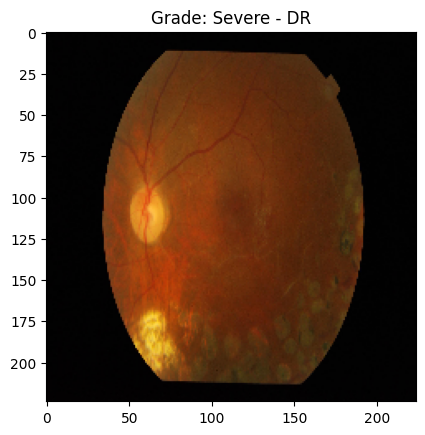

In [5]:
plot_random_image()

In [6]:
# Check the properties of our image, change shape to [C, H, W]

from PIL import Image
import torchvision
from torchvision.transforms import v2

# Get a random image
labels = next(os.walk(dataset_path))[1]
random_index = random.randint(1, len(labels))
random_label = labels[random_index]

label_dir = dataset_path / random_label

random_image_path = label_dir / random.choice(os.listdir(label_dir))

img = Image.open(random_image_path)

transform = v2.Compose([
    v2.PILToTensor(),
    v2.Resize((224,224)),
    v2.ConvertImageDtype(dtype=torch.float32),
    v2.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

img_tensor = transform(img)

In [7]:
type(img_tensor), img_tensor.shape, img_tensor

(torch.Tensor,
 torch.Size([3, 224, 224]),
 tensor([[[-0.9765, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9608],
          [-0.9686, -0.9686, -0.9686,  ..., -0.9765, -0.9686, -0.9686],
          [-0.9608, -0.9686, -0.9686,  ..., -0.9765, -0.9686, -0.9608],
          ...,
          [-0.9686, -0.9686, -0.9686,  ..., -0.9686, -0.9686, -0.9608],
          [-0.9686, -0.9608, -0.9608,  ..., -0.9608, -0.9608, -0.9686],
          [-0.9686, -0.9686, -0.9608,  ..., -0.9686, -0.9608, -0.9686]],
 
         [[-0.9686, -0.9686, -0.9765,  ..., -0.9608, -0.9765, -0.9608],
          [-0.9765, -0.9765, -0.9686,  ..., -0.9608, -0.9765, -0.9686],
          [-0.9608, -0.9686, -0.9765,  ..., -0.9686, -0.9765, -0.9686],
          ...,
          [-0.9765, -0.9608, -0.9608,  ..., -0.9686, -0.9686, -0.9765],
          [-0.9686, -0.9608, -0.9765,  ..., -0.9608, -0.9765, -0.9686],
          [-0.9608, -0.9686, -0.9686,  ..., -0.9765, -0.9686, -0.9686]],
 
         [[-0.9529, -0.9529, -0.9373,  ..., -0.9373, -0.9

In [8]:
# Create `dataset` object
from torchvision import datasets
from torch.utils.data import random_split

# Create transformation pipelines AND for data augmentation
train_transform = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=15),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    v2.Resize((224,224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_transform = v2.Compose([
    v2.Resize((224,224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

full_dataset = datasets.ImageFolder(root=dataset_path)

idx_labels = full_dataset.class_to_idx

# Define train and test size
train_size = int(0.8 * len(full_dataset))
test_size = int(len(full_dataset) - train_size)

# splitting the dataset
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# applying different transforms
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [9]:
# See how many images we are dealing with
print(f'Training dataset: {len(train_dataset)}')
print(f'Testing dataset: {len(test_dataset)}')

Training dataset: 2929
Testing dataset: 733


> Before creating a `dataset` object, make sure you have the structure for your dataset:

```
├── train
│   ├── class1
|      ├── 1.jpg
│      ├── 2.jpg
│   ├── class2
|      ├── 1.jpg
│      ├── 2.jpg
├── valid
│   ├── class1
|      ├── 1.jpg
│      ├── 2.jpg
│   ├── class2
|      ├── 1.jpg
│      ├── 2.jpg
```

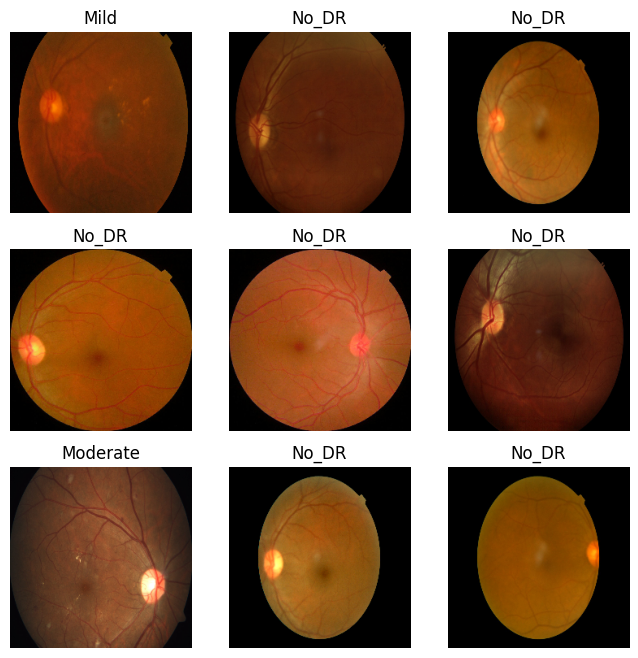

In [10]:
# Visualizing our data

def unnormalize(img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    img = img.clone()  # Avoid modifying original tensor
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # reverse normalization: (img * std) + mean
    return img

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    img = unnormalize(img) # Unnormalized temporarily for visualization
    figure.add_subplot(rows, cols, i)
    plt.title(list(idx_labels.keys())[list(idx_labels.values()).index(label)])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [11]:
# Create `DataLoader` object

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [12]:
# See dataloader batch data
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Get single image and label, check their shapes
single_img = train_features[0]
label = train_labels[0]

print(f'Single Image: {single_img.shape}')
print(f'Label: {label}, {type(label)}')

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])
Single Image: torch.Size([3, 224, 224])
Label: 2, <class 'torch.Tensor'>


## Training

In this section, we are going to:

- Create our Torch class parameters
- Create a method for training and testing our models
- Use visualizations to assess the model

In [13]:
# Creating NN Torch class

class DR_Classifier(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int = 10):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1,
                      ),
            nn.BatchNorm2d(hidden_units),
            nn.LeakyReLU(0.1),
            nn.Conv2d(hidden_units,
                      hidden_units,
                      3,
                      1,
                      1), # These are already in default value, except kernel_size
            nn.BatchNorm2d(hidden_units),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(hidden_units * 2, hidden_units * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(hidden_units * 2, hidden_units * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 4),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 4 * 28 * 28, 512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(512, output_shape)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

model_1 = DR_Classifier(input_shape=3, output_shape=len(idx_labels), hidden_units=25)
model_1, model_1.parameters

(DR_Classifier(
   (block1): Sequential(
     (0): Conv2d(3, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): LeakyReLU(negative_slope=0.1)
     (3): Conv2d(25, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): LeakyReLU(negative_slope=0.1)
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Dropout(p=0.3, inplace=False)
   )
   (block2): Sequential(
     (0): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): LeakyReLU(negative_slope=0.1)
     (3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): LeakyReLU(n

In [36]:
# Create a train and testing method
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device
               ) -> None:
    """
    Trains the current batch of the `data_loader`.

    Args:
        model (nn.Module): A PyTorch model to train your data
        data_loader (DataLoader): The dataloader to train your model
        loss_fn (torch.nn.Module): The loss function to calculate the performance of model
        optimizer (torch.optim.Optimizer): The optimizer to use
        accuracy_fn: Will caculate the accuracy of your model's predictions
        device: Where your data is stored

    Returns:
        None
    """

    model.to(device)
    train_loss, train_acc = 0, 0
    total_batches = len(data_loader)
    for batch, (X, y) in enumerate(data_loader):

        X, y = X.to(device), y.to(device)

        # Do predictions
        y_pred = model(X)

        # Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        acc = accuracy_fn(y_pred.argmax(dim=1), y)
        train_acc += acc.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"[Train] Batch {batch + 1}/{total_batches} | Loss: {loss.item():.5f} | Acc: {acc:.2f}% | Images Processed: {len(X)}")

    train_loss /= total_batches
    train_acc /= total_batches
    print(f"[Train Summary] Avg Loss: {train_loss:.5f} | Avg Acc: {train_acc:.2f}%\n")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device
              ):
    """
    Evaluates the current batch of the `data_loader`.

    Args:
        model (nn.Module): A PyTorch model to train your data
        data_loader (DataLoader): The dataloader to train your model
        loss_fn (torch.nn.Module): The loss function to calculate the performance of model
        accuracy_fn: Will caculate the accuracy of your model's predictions
        device: Where your data is stored

    Returns:
        None
    """
    model.to(device)
    test_loss, test_acc = 0, 0
    total_batches = len(data_loader)
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(data_loader):

            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred = model(X)

            # Calculate loss and accuracy
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            acc = accuracy_fn(test_pred.argmax(dim=1), y)
            test_acc += acc.item()

            print(f"[Test] Batch {batch + 1}/{total_batches} | Loss: {loss.item():.5f} | Acc: {acc:.2f}% | Images Processed: {len(X)}")

        test_loss /= total_batches
        test_acc /= total_batches
        print(f"[Test Summary] Avg Loss: {test_loss:.5f} | Avg Acc: {test_acc:.2f}%\n")

In [37]:
# Get our device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1.to(DEVICE)

DEVICE

device(type='cuda')

In [43]:
# Setting up optimizer and loss functions
from torchmetrics.classification import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)
acc_fn = Accuracy(task="multiclass", num_classes=len(idx_labels)).to(DEVICE)

In [44]:
# Perform a sample prediction before training
single_img = single_img.to(DEVICE)
label = label.to(DEVICE)
with torch.inference_mode():
    # [3, 224, 224] -> [1, 3, 224, 224]
    pred = model_1(single_img.unsqueeze(0)) # Unsqueeze adds another dimension (do not add in dataloaders)
    loss = loss_fn(pred, label.unsqueeze(0))

print(f'Actual value: {label}\nPredicted value: {pred.argmax(dim=1).item()} \nLoss: {loss.item()}')

Actual value: 2
Predicted value: 3 
Loss: 122.1247329711914


In [45]:
# Training our model
EPOCHS = 3

for epoch in range(EPOCHS):
    print(f'Epoch: {epoch+1}\n----------------------------------')
    train_step(
        model=model_1,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=acc_fn,
        device=DEVICE
    )

    test_step(
        model=model_1,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=acc_fn,
        device=DEVICE
    )

    print(f'-------------------------------------\n\n')

Epoch: 1
----------------------------------
[Train] Batch 1/46 | Loss: 169.43680 | Acc: 0.20% | Images Processed: 64
[Train] Batch 2/46 | Loss: 127.45097 | Acc: 0.31% | Images Processed: 64
[Train] Batch 3/46 | Loss: 56.77249 | Acc: 0.59% | Images Processed: 64
[Train] Batch 4/46 | Loss: 74.41563 | Acc: 0.47% | Images Processed: 64
[Train] Batch 5/46 | Loss: 61.88411 | Acc: 0.52% | Images Processed: 64
[Train] Batch 6/46 | Loss: 48.11280 | Acc: 0.56% | Images Processed: 64
[Train] Batch 7/46 | Loss: 54.10583 | Acc: 0.53% | Images Processed: 64
[Train] Batch 8/46 | Loss: 52.85926 | Acc: 0.47% | Images Processed: 64
[Train] Batch 9/46 | Loss: 48.48994 | Acc: 0.53% | Images Processed: 64
[Train] Batch 10/46 | Loss: 55.74837 | Acc: 0.48% | Images Processed: 64
[Train] Batch 11/46 | Loss: 87.90504 | Acc: 0.38% | Images Processed: 64
[Train] Batch 12/46 | Loss: 63.18893 | Acc: 0.50% | Images Processed: 64
[Train] Batch 13/46 | Loss: 50.62201 | Acc: 0.48% | Images Processed: 64
[Train] Batch 

## Saving and Loading

In this section, we are going to:

- Save the trained PyTorch model
- Load the PyTorch model
- Perform a basic prediction on the loaded model

In [41]:
# Saving the trained PyTorch model
MODEL_PATH = Path(r'./dataset')

# Create model save path
MODEL_NAME = "grader.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")

torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: dataset/grader.pth


In [42]:
# Loading the PyTorch model!
loaded_model = DR_Classifier(input_shape=3,
                                hidden_units=10, # try changing this to 128 and seeing what happens
                                output_shape=len(idx_labels))

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to DEVICE
loaded_model = loaded_model.to(DEVICE)

RuntimeError: Error(s) in loading state_dict for DR_Classifier:
	size mismatch for block1.0.weight: copying a param with shape torch.Size([25, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([10, 3, 3, 3]).
	size mismatch for block1.0.bias: copying a param with shape torch.Size([25]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for block1.1.weight: copying a param with shape torch.Size([25]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for block1.1.bias: copying a param with shape torch.Size([25]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for block1.1.running_mean: copying a param with shape torch.Size([25]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for block1.1.running_var: copying a param with shape torch.Size([25]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for block1.3.weight: copying a param with shape torch.Size([25, 25, 3, 3]) from checkpoint, the shape in current model is torch.Size([10, 10, 3, 3]).
	size mismatch for block1.3.bias: copying a param with shape torch.Size([25]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for block1.4.weight: copying a param with shape torch.Size([25]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for block1.4.bias: copying a param with shape torch.Size([25]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for block1.4.running_mean: copying a param with shape torch.Size([25]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for block1.4.running_var: copying a param with shape torch.Size([25]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for block2.0.weight: copying a param with shape torch.Size([50, 25, 3, 3]) from checkpoint, the shape in current model is torch.Size([20, 10, 3, 3]).
	size mismatch for block2.0.bias: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for block2.1.weight: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for block2.1.bias: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for block2.1.running_mean: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for block2.1.running_var: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for block2.3.weight: copying a param with shape torch.Size([50, 50, 3, 3]) from checkpoint, the shape in current model is torch.Size([20, 20, 3, 3]).
	size mismatch for block2.3.bias: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for block2.4.weight: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for block2.4.bias: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for block2.4.running_mean: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for block2.4.running_var: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for block3.0.weight: copying a param with shape torch.Size([100, 50, 3, 3]) from checkpoint, the shape in current model is torch.Size([40, 20, 3, 3]).
	size mismatch for block3.0.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for block3.1.weight: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for block3.1.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for block3.1.running_mean: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for block3.1.running_var: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for classifier.1.weight: copying a param with shape torch.Size([512, 78400]) from checkpoint, the shape in current model is torch.Size([512, 31360]).